### Installing Requirements

Mouting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Getting the repo for yolo.

In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14776, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 14776 (delta 56), reused 78 (delta 46), pack-reused 14677
Receiving objects: 100% (14776/14776), 13.53 MiB | 6.55 MiB/s, done.
Resolving deltas: 100% (10200/10200), done.


Getting the requirements for yolov5

In [5]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.4 MB/s 


Adding the dependencies

In [6]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

### Setting up the annotations.


The dataset is available <a href = "https://www.shorturl.at/ahAY4">here.</a>

In [8]:
%cd /contente/drive/MyDrive/AlignedDataset/
!unzip /content/drive/MyDrive/AlignedDataset/aligned.zip

Streaming output truncated to the last 5000 lines.
  inflating: align/AnnotatedImages/FLIR_03235_RGB.jpg  
  inflating: align/AnnotatedImages/FLIR_07995_RGB.jpg  
  inflating: align/AnnotatedImages/FLIR_02636_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_04461_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_05159_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_05338_RGB.jpg  
  inflating: align/AnnotatedImages/FLIR_00642_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_04657_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_05220_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_03425_RGB.jpg  
  inflating: align/AnnotatedImages/FLIR_01924_RGB.jpg  
  inflating: align/AnnotatedImages/FLIR_01924_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_02738_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_04166_PreviewData.jpeg  
  inflating: align/AnnotatedImages/FLIR_07350_PreviewData.jpeg  
  inflating: align/

In [12]:
%ls

align_train.txt       AnnotatedImages/  JPEGImages/
align_validation.txt  Annotations/


Cleaning data by deleting masks and other unnecessary images.

In [26]:
from glob import glob
import os
imgstodel = glob('./Annotations/*mask.jpg')
for i in imgstodel:
  try:
    os.remove(i)
  except:
    print(i)

Converting the annotations from POC XML to yolo

In [16]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

Checking changed annotations.

In [17]:
print(extract_info_from_xml('Annotations/FLIR_00002_PreviewData.xml'))

{'bboxes': [{'class': 'car', 'xmin': 396, 'ymin': 200, 'xmax': 543, 'ymax': 250}, {'class': 'car', 'xmin': 324, 'ymin': 206, 'xmax': 345, 'ymax': 225}, {'class': 'car', 'xmin': 273, 'ymin': 196, 'xmax': 287, 'ymax': 210}, {'class': 'car', 'xmin': 307, 'ymin': 197, 'xmax': 322, 'ymax': 211}, {'class': 'car', 'xmin': 262, 'ymin': 195, 'xmax': 274, 'ymax': 208}, {'class': 'car', 'xmin': 252, 'ymin': 198, 'xmax': 265, 'ymax': 212}], 'filename': 'FLIR_00002.jpeg', 'image_size': (640, 512, 3)}


Mapping classes and converting annotations

In [18]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {'car': 0, 'person': 1, 'bicycle': 2, 'dog': 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            #class_name_to_id_mapping[b["class"]] = len(class_name_to_id_mapping.keys())
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("AnnotationsTXT", info_dict["filename"].replace("jpeg", "txt"))
    if not os.path.isdir('AnnotationsTXT'):
      os.makedirs('AnnotationsTXT')
    # Save the annotation to disk
    f = open(save_file_name, "w")
    print("\n".join(print_buffer), file= f)

In [19]:
# Get the annotations
annotations = [os.path.join('Annotations', x) for x in os.listdir('Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('AnnotationsTXT', x) for x in os.listdir('AnnotationsTXT') if x[-3:] == "txt"]

100%|██████████| 5142/5142 [01:04<00:00, 79.23it/s]


In [20]:
annotations = [os.path.join('AnnotationsTXT', x) for x in os.listdir('AnnotationsTXT') if x[-3:] == "txt"]
annotations #checking for the extension for each file

['AnnotationsTXT/FLIR_00002.txt',
 'AnnotationsTXT/FLIR_00003.txt',
 'AnnotationsTXT/FLIR_00004.txt',
 'AnnotationsTXT/FLIR_00006.txt',
 'AnnotationsTXT/FLIR_00007.txt',
 'AnnotationsTXT/FLIR_00008.txt',
 'AnnotationsTXT/FLIR_00010.txt',
 'AnnotationsTXT/FLIR_00011.txt',
 'AnnotationsTXT/FLIR_00012.txt',
 'AnnotationsTXT/FLIR_00013.txt',
 'AnnotationsTXT/FLIR_00014.txt',
 'AnnotationsTXT/FLIR_00015.txt',
 'AnnotationsTXT/FLIR_00016.txt',
 'AnnotationsTXT/FLIR_00018.txt',
 'AnnotationsTXT/FLIR_00019.txt',
 'AnnotationsTXT/FLIR_00021.txt',
 'AnnotationsTXT/FLIR_00022.txt',
 'AnnotationsTXT/FLIR_00024.txt',
 'AnnotationsTXT/FLIR_00025.txt',
 'AnnotationsTXT/FLIR_00026.txt',
 'AnnotationsTXT/FLIR_00030.txt',
 'AnnotationsTXT/FLIR_00033.txt',
 'AnnotationsTXT/FLIR_00035.txt',
 'AnnotationsTXT/FLIR_00039.txt',
 'AnnotationsTXT/FLIR_00040.txt',
 'AnnotationsTXT/FLIR_00044.txt',
 'AnnotationsTXT/FLIR_00045.txt',
 'AnnotationsTXT/FLIR_00046.txt',
 'AnnotationsTXT/FLIR_00049.txt',
 'AnnotationsT

Remove JPEG Image files and other unnecessary files

In [25]:
os.remove('./align_train.txt')
os.remove('./align_validation.txt')

In [32]:
JPEG = glob('./JPEGImages/*RGB.jpg')
for image in JPEG:
  os.remove(image)

In [60]:
images = glob('./*')
temp = []
for image in images:
  tempName = image[2:]
  tempName = tempName[:len(tempName) - 17]
  tempName = './' + tempName + '.jpeg'
  os.rename(image, tempName)

In [62]:
#checking if the jpegs were named
%ls
%cd ../

FLIR_00002.jpeg  FLIR_02398.jpeg  FLIR_04304.jpeg  FLIR_07424.jpeg
FLIR_00003.jpeg  FLIR_02399.jpeg  FLIR_04305.jpeg  FLIR_07425.jpeg
FLIR_00004.jpeg  FLIR_02400.jpeg  FLIR_04306.jpeg  FLIR_07426.jpeg
FLIR_00006.jpeg  FLIR_02401.jpeg  FLIR_04307.jpeg  FLIR_07427.jpeg
FLIR_00007.jpeg  FLIR_02402.jpeg  FLIR_04308.jpeg  FLIR_07432.jpeg
FLIR_00008.jpeg  FLIR_02408.jpeg  FLIR_04309.jpeg  FLIR_07434.jpeg
FLIR_00010.jpeg  FLIR_02413.jpeg  FLIR_04310.jpeg  FLIR_07436.jpeg
FLIR_00011.jpeg  FLIR_02415.jpeg  FLIR_04311.jpeg  FLIR_07437.jpeg
FLIR_00012.jpeg  FLIR_02416.jpeg  FLIR_04313.jpeg  FLIR_07438.jpeg
FLIR_00013.jpeg  FLIR_02417.jpeg  FLIR_04314.jpeg  FLIR_07442.jpeg
FLIR_00014.jpeg  FLIR_02418.jpeg  FLIR_04315.jpeg  FLIR_07446.jpeg
FLIR_00015.jpeg  FLIR_02419.jpeg  FLIR_04316.jpeg  FLIR_07447.jpeg
FLIR_00016.jpeg  FLIR_02420.jpeg  FLIR_04334.jpeg  FLIR_07448.jpeg
FLIR_00018.jpeg  FLIR_02421.jpeg  FLIR_04335.jpeg  FLIR_07449.jpeg
FLIR_00019.jpeg  FLIR_02422.jpeg  FLIR_04341.jpeg  FLIR_07453.

JPEGImages/FLIR_01007.jpeg


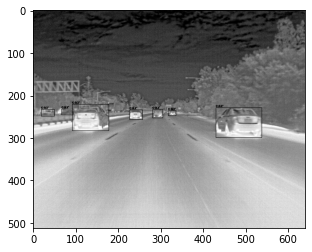

In [76]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("AnnotationsTXT", "JPEGImages").replace(".txt", ".jpeg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [91]:
# Read images and annotations
images = [os.path.join('JPEGImages', x) for x in os.listdir('JPEGImages')]
annotations = [os.path.join('AnnotationsTXT', x) for x in os.listdir('AnnotationsTXT') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [89]:
%mkdir './data/'
%mkdir './ann'

In [ ]:
import shutil
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in tqdm(list_of_files):
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'data/train/')
move_files_to_folder(val_images, 'data/val/')
move_files_to_folder(test_images, 'data/test/')
move_files_to_folder(train_annotations, 'ann/train/')
move_files_to_folder(val_annotations, 'ann/val/')
move_files_to_folder(test_annotations, 'ann/test/')

Since we have effectively cleaned our dataset all we have to do now is to change the yaml file we have for yolo to give it the paths to the train, val and test images along with its annotations. We also need to create a *hyp.scratch.yaml* file to include the hyperparameter

### Training the model

Now we need to simply run the train.py file that we got from the github repo. We have to give it some parameters such as:


1.   The image size
2. The config file
3. The hyper parameter file
4. The batch size
5.  Number of epochs
6. The data paths
7. The weights for the yolo model
8. The number of workers
9. The name of the file you want to store the result as




In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 50 --data flir_data.yaml --weights yolov5s.pt --workers 24 --name yolo_flir_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=flir_data.yaml, hyp=hyp.scratch.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_flir_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-208-g8236d88 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: copy_paste=0.0, lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.

We achieved an accuracy of 89% which could be increased with more of number of epochs but for now this would do.

###Inference

We can now take a look at the images that we are going to test the model. The images have been taken from a different dataset and randomly plucked from a simple Google search.

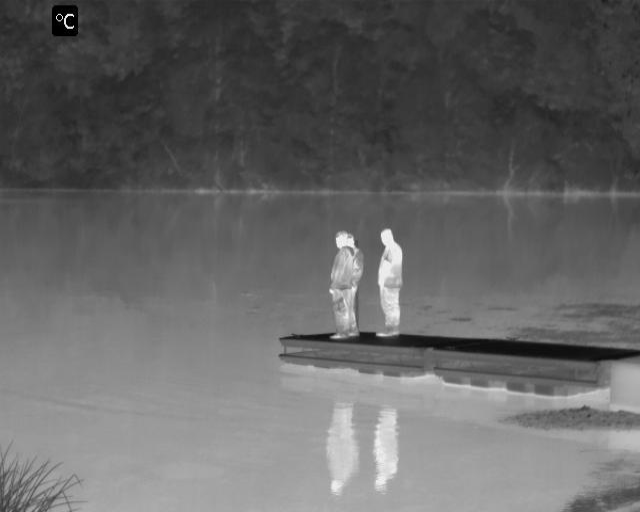

In [102]:
import cv2 as cv
from google.colab.patches import cv2_imshow
img = cv.resize(cv.imread('./randomtest-01.jpeg'),(640,512))
cv2_imshow(img)


In [106]:
!python detect.py --source '../randomTest/randomtest-01.jpeg' --weights runs/train/yolo_flir_det/weights/best.pt --conf 0.25 --name yolo_video_result

detect: weights=['runs/train/yolo_flir_det/weights/best.pt'], source=../randomTest/randomtest-01.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_video_result, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-208-g8236d88 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/randomTest/randomtest-01.jpeg: 480x640 2 persons, 298.6ms
Speed: 2.8ms pre-process, 298.6ms inference, 23.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_video_result2


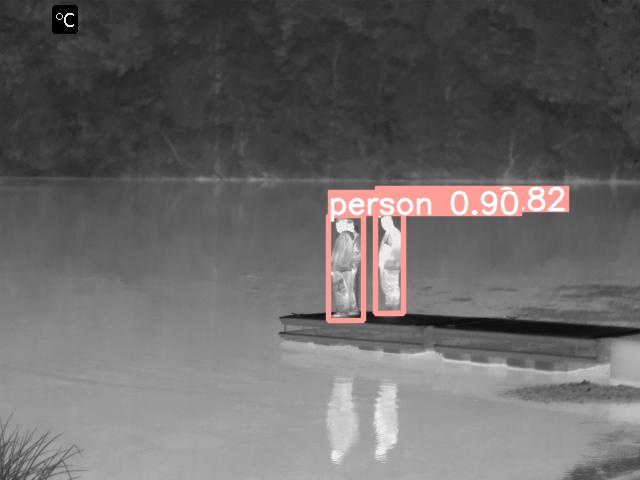

In [107]:
result_img = cv.imread('runs/detect/yolo_video_result2/randomtest-01.jpeg')
cv2_imshow(result_img)

### Exporting the model

In [ ]:
!python export.py --weights yolov5s.pt --include saved_model

export: data=data/coco128.yaml, weights=['yolov5s.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['saved_model']
YOLOv5 🚀 v6.2-208-g8236d88 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from yolov5s.pt with output shape (1, 25200, 85) (14.1 MB)

TensorFlow SavedModel: starting export with tensorflow 2.9.2...

                 from  n    params  module                                  arguments                     
2022-11-01 19:25:50.755277: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
  0                -1  1      3520  models.common.Conv                      [3, 32, 

### Model Accuracy Visualization

Yolov5 saves several plots with training history that can be found in its directories

In [114]:
os.chdir('./runs/train/yolo_flir_det/')

In [118]:
%ls

confusion_matrix.png                               results.png
events.out.tfevents.1666724901.2ae18f24a3fe.412.0  train_batch0.jpg
F1_curve.png                                       train_batch1.jpg
hyp.yaml                                           train_batch2.jpg
labels_correlogram.jpg                             val_batch0_labels.jpg
labels.jpg                                         val_batch0_pred.jpg
opt.yaml                                           val_batch1_labels.jpg
P_curve.png                                        val_batch1_pred.jpg
PR_curve.png                                       val_batch2_labels.jpg
R_curve.png                                        val_batch2_pred.jpg
results.csv                                        weights/


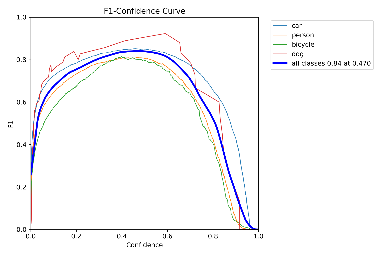

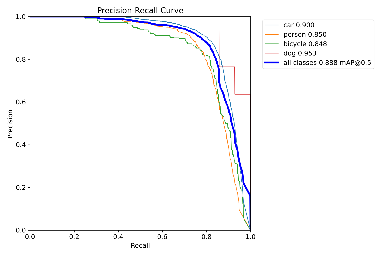

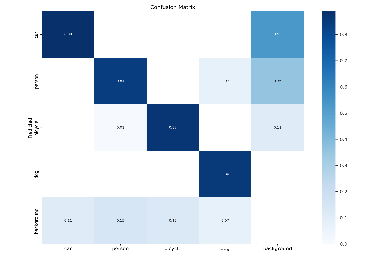

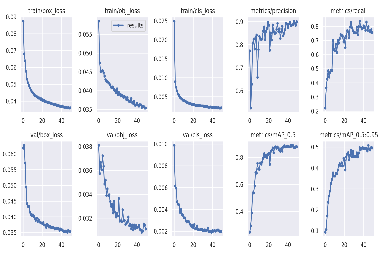

In [127]:

f1_curve = cv.resize(cv.imread('F1_curve.png') ,(384,256))
conf_matrix = cv.resize(cv.imread('confusion_matrix.png') ,(384,256))
PR_curve = cv.resize(cv.imread('PR_curve.png') ,(384,256))
loss_acc_res = cv.resize(cv.imread('results.png') ,(384,256))


cv2_imshow(f1_curve)
cv2_imshow(PR_curve)
cv2_imshow(conf_matrix)
cv2_imshow(loss_acc_res)